# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

Imports

In [2]:
## Imports
import zipfile
import os
import pandas as pd
import numpy as np
import time

from scipy.stats import normaltest
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
#from sklearn import svm
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Ensembling
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



Cloning into 'tm10007_ml'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 87 (delta 9), reused 8 (delta 8), pack-reused 73 (from 1)
Receiving objects: 100% (87/87), 67.99 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (31/31), done.
The number of samples: 827
The number of columns: 9001


**Pre-processing**

Separate labels

In [4]:
# Data has a 'label' column indicating the class
label = data['label']

# Separate data based on the label
if sum(data['label']) > len(data) / 2:
    normal_data = data[label == 0]
    abnormal_data = data[label == 1]
else:
    normal_data = data[label == 1]
    abnormal_data = data[label == 0]

# Create data without the labels
data_no_label = data.drop('label', axis=1)  # All features

Missing data handling

In [5]:
##### Check for missing data
# Check for any None values in data
has_missing = data.isnull().values.any()
print(f"Missing values present? {has_missing}")

# Check for any zeros in data
has_zeros = (data_no_label == 0).values.any()
print(f"Zero values present? {has_zeros}")

# Calculate total number of zeros
total_zeros = (data_no_label == 0).sum().sum()
print(f"Total zeros in DataFrame: {total_zeros}")

##### Overview of where zeros are to decide missing data handling strategy
# Count how many rows have at least one zero
rows_with_zero = (data_no_label == 0).any(axis=1).sum()
print(f"Number of rows with at least one zero: {rows_with_zero}")

# Count how many columns have at least one zero
columns_with_zero = (data_no_label == 0).any(axis=0).sum()
print(f"Number of columns with at least one zero: {columns_with_zero}")

# Create table with zero count for the rows
zero_counts_per_row = (data_no_label == 0).sum(axis=1)
zero_count_table = pd.DataFrame({'Row_Index': data_no_label.index, 'Zero_Count': zero_counts_per_row})
zero_count_table.set_index('Row_Index', inplace=True)

# Create table with zero count for the columns
zero_counts_per_column = (data_no_label == 0).sum(axis=0)
zero_count_table = pd.DataFrame({'Column_Name': zero_counts_per_column.index, 'Zero_Count': zero_counts_per_column.values})
zero_count_table.set_index('Column_Name', inplace=True)

##### Remove missing data
# Remove rows with more than 10 zeros
zero_counts_per_row = (data_no_label == 0).sum(axis=1)
rows_to_keep = zero_counts_per_row[zero_counts_per_row <= 10].index
filtered_data = data_no_label.loc[rows_to_keep]
filtered_label = label.loc[rows_to_keep]

# Print removed rows with zeros
data_with_zeros = data_no_label[(data_no_label == 0).any(axis=1)]
zero_counts_per_row = (data_with_zeros == 0).sum(axis=1)
#print(zero_counts_per_row)

# Check if all rows with zeros are removed
rows_with_zero = (filtered_data == 0).any(axis=1).sum()
print(f"Number of rows with at least one zero (filtered data): {rows_with_zero}")

# Calculate total number of zeros to make sure all are removed from the whole dataframe
total_zeros = (filtered_data == 0).sum().sum()
print(f"Total zeros in the DataFrame (excluding last column) after removing rows with zeros: {total_zeros}")

Missing values present? False
Zero values present? True
Total zeros in DataFrame: 10500
Number of rows with at least one zero: 14
Number of columns with at least one zero: 4500
Number of rows with at least one zero (filtered data): 0
Total zeros in the DataFrame (excluding last column) after removing rows with zeros: 0


Train and test data

In [6]:
# Split the data into training and testing set (for final evaluation als dit nodig is)
data_train, data_test, label_train, label_test = train_test_split(filtered_data, filtered_label, test_size=0.2, random_state=42, stratify=filtered_label)

# Define K-fold cross-validation
n_folds = 2
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

Scaling

In [23]:
# Normal distribution of features
p_values = data_train.apply(lambda col: normaltest(col)[1])
non_normal_features = (p_values < 0.05).sum() # a p-value > 0.05 means it is not normally distributed
print(f'Number of not normal distributed features: {non_normal_features} van {len(data_train.columns)}')

# Find outliers in data
def count_outliers(df):
  '''function to detect outliers in data'''
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = ((df < lower_bound) | (df > upper_bound)).sum()
  return outliers

outlier_counts = count_outliers(data_train)
mean_outliers = outlier_counts.mean()
features_with_many_outliers = (outlier_counts > 0.1 * len(data_train.index)).sum()
print(f'Number of features with >10% outliers: {features_with_many_outliers}')

# Robust scaler chosen: based on normal distribution and outliers
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_train)
data_scaled = pd.DataFrame(data_scaled, columns=data_train.columns, index=data_train.index)

Aantal features met outliers 411
Aantal niet-normaal verdeelde features: 9000 van 9000
Suggestie voor scaling: Gebruik MinMaxScaler (geen normale verdeling, weinig outliers)


**Feature selection and extraction**

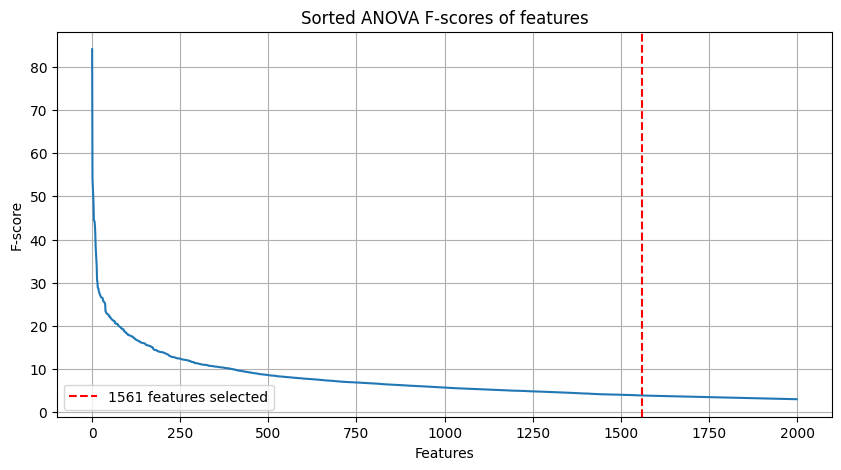

Univariatiate statistical feature selection performed: 1561 features selected.


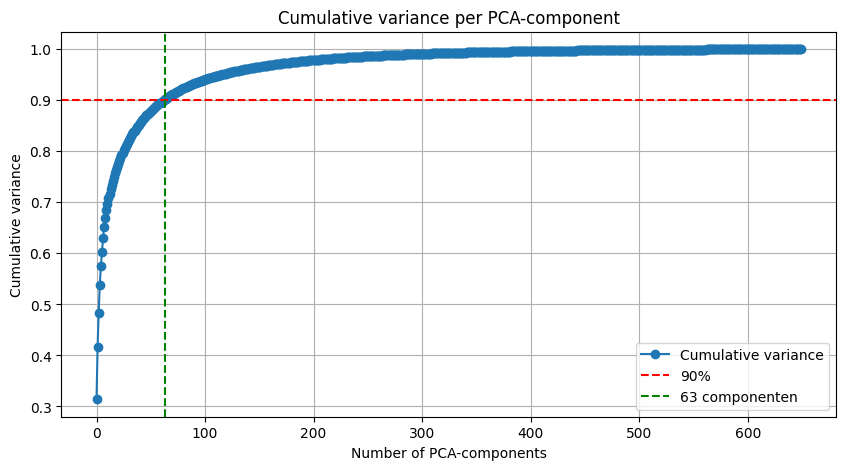

PCA feature selection performed: 63 features left.


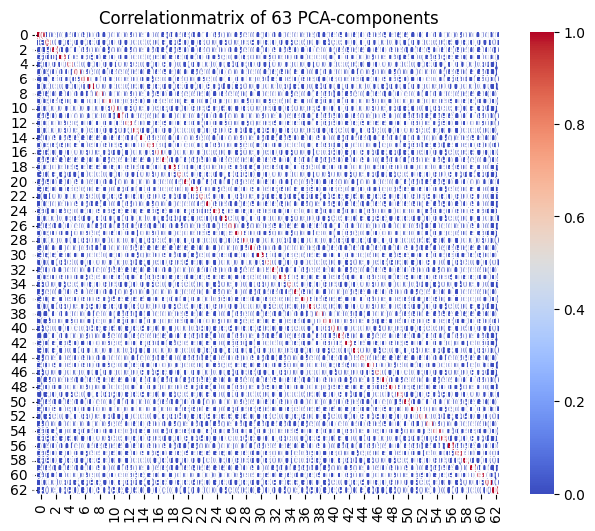

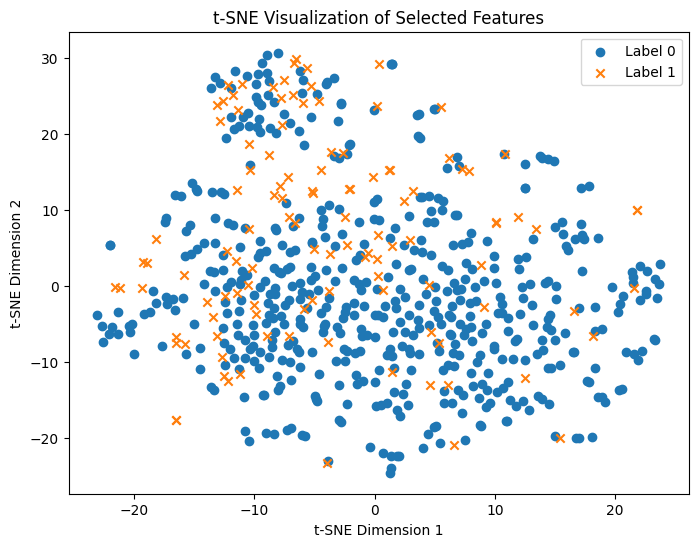

In [34]:
# 1. Preliminary filtering using univariate statistical testing: ANOVA f-test
# Number of features for p < 0.05
f_scores, p_values = f_classif(data_scaled, label_train)
sorted_scores = np.sort(f_scores)[::-1]  # Sort descending
k_best = np.sum(p_values < 0.05) # Only features with p_value < 0.05

# Visualize f-scores
plt.figure(figsize=(10,5))
plt.plot(sorted_scores[:2000])
plt.axvline(x=k_best, color='r', linestyle='--', label=f'{k_best} features selected')
plt.title('Sorted ANOVA F-scores of features')
plt.xlabel('Features')
plt.ylabel('F-score')
plt.legend()
plt.grid(True)
plt.show()

selector = SelectKBest(f_classif, k=k_best) # Select top features
data_selected = selector.fit_transform(data_scaled, label_train) # Fit to the training data

# Get the feature names
selected_feature_indices = selector.get_support(indices=True)  # Get indices of selected features
selected_feature_names = data_scaled.columns[selector.get_support()] # Data is pandas dataframe
data_selected = pd.DataFrame(data_selected, columns=selected_feature_names, index=data_scaled.index)

print(f'Univariatiate statistical feature selection performed: {k_best} features selected.')

# 2. Dimensionality reduction using PCA
# Number of components for ≥90% variance
pca_full = PCA().fit(data_selected)
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
pca_components = np.argmax(cumulative_var >= 0.90) + 1

# Plot variance
plt.figure(figsize=(10,5))
plt.plot(cumulative_var, marker='o', label='Cumulative variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90%')
plt.axvline(x=pca_components, color='g', linestyle='--', label=f'{pca_components} componenten')
plt.title('Cumulative variance per PCA-component')
plt.xlabel('Number of PCA-components')
plt.ylabel('Cumulative variance')
plt.legend()
plt.grid(True)
plt.show()

pca = PCA(n_components=pca_components)  # Reduce to features so that variance > 0.9
data_pca_selected = pca.fit_transform(data_selected) # Fit to the training data
data_pca_selected = pd.DataFrame(data_pca_selected, index=data_selected.index)

print(f'PCA feature selection performed: {pca_components} features left.')

# Correlation matrix of PCA-components
plt.figure(figsize=(8,6))
sns.heatmap(data_pca_selected.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Correlationmatrix of {pca_components} PCA-components')
plt.show()

# 3. Visualize new features with t-SNE
tsne = TSNE(n_components=2, random_state=42) # Reduce to 2 dimensions for plotting
data_tsne = tsne.fit_transform(data_pca_selected)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[label_train == 0, 0], data_tsne[label_train == 0, 1], label='Label 0', marker='o')  # Plot points for label 0
plt.scatter(data_tsne[label_train == 1, 0], data_tsne[label_train == 1, 1], label='Label 1', marker='x')  # Plot points for label 1
plt.legend()  # Add a legend to identify the labels
plt.title('t-SNE Visualization of Selected Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# **Classify**

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.war

Classifier: LinearDiscriminantAnalysis
Average AUC: 0.724600680806494
Average F1-score: 0.38181818181818183
Average Accuracy: 0.8215384615384616
Classifier: QuadraticDiscriminantAnalysis
Average AUC: 0.5
Average F1-score: 0.0
Average Accuracy: 0.8246153846153846
Classifier: LogisticRegression
Average AUC: 0.6999869075674261
Average F1-score: 0.397979797979798
Average Accuracy: 0.8153846153846154
Classifier: GaussianNB
Average AUC: 0.6747839748625294
Average F1-score: 0.3611111111111111
Average Accuracy: 0.8061538461538462
Classifier: SGDClassifier
Average AUC: 0.5993715632364492
Average F1-score: 0.33697785253714607
Average Accuracy: 0.7553846153846153
Classifier: KNeighborsClassifier
Average AUC: 0.6203358208955223
Average F1-score: 0.10965588084232153
Average Accuracy: 0.8292307692307692
Classifier: DecisionTreeClassifier
Average AUC: 0.5878338570306363
Average F1-score: 0.3129459734964322
Average Accuracy: 0.7815384615384615
Classifier: SVC
Average AUC: 0.7283647551715109
Average F1

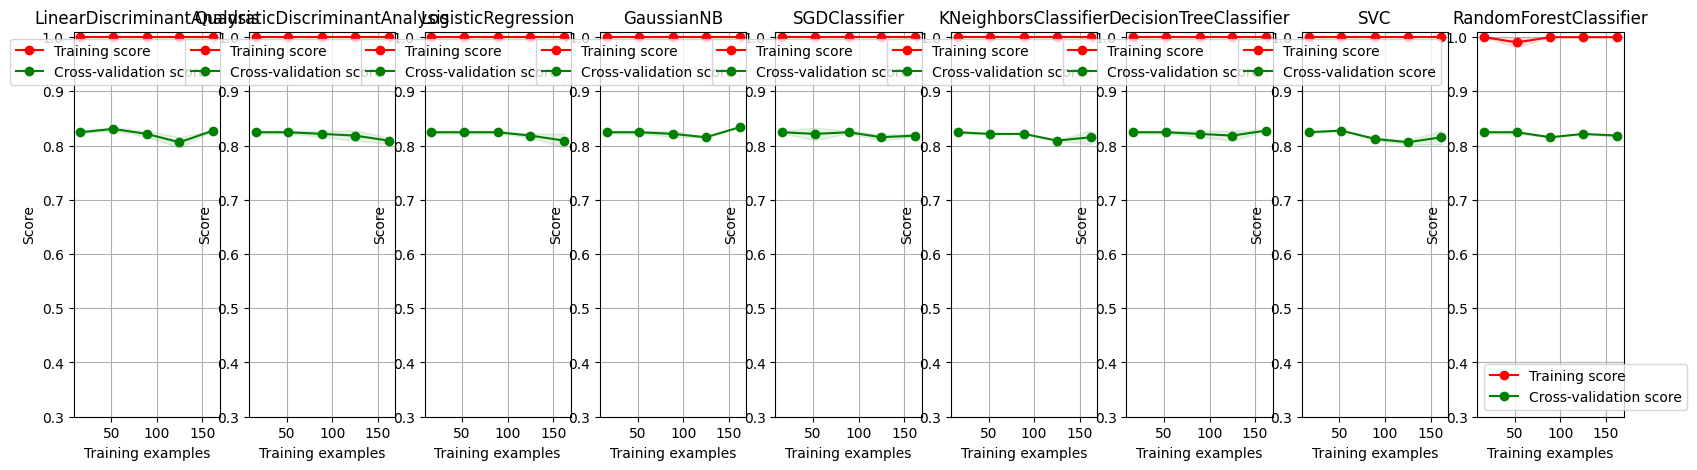

In [ ]:

classifiers = {
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(),
    "LogisticRegression": LogisticRegression(),
    "GaussianNB": GaussianNB(),
    "SGDClassifier": SGDClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "SVC": SVC(),
    "RandomForestClassifier": RandomForestClassifier(),
}

auc_scores = {}
f1_scores = {}
acc_scores = {}
fig, axes = plt.subplots(1, len(classifiers), figsize=(20, 5))

i=0

for train_index, val_index in cv.split(data_train, label_train):
    # split data into train and validation for this fold
    X_train, X_val = data_train.iloc[train_index], data_train.iloc[val_index]
    y_train, y_val = label_train.iloc[train_index], label_train.iloc[val_index]

    # scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # feature selection
    # univariate statistical selection
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_val_selected = selector.transform(X_val_scaled)

    # PCA
    pca.fit(X_train_selected, y_train)
    X_train_final_selected = pca.transform(X_train_selected)
    X_val_final_selected = pca.transform(X_val_selected)

    for clf_name,clf in classifiers.items():
      # train the classifier on the selected features
      clf.fit(X_train_final_selected, y_train)
      y_pred = clf.predict(X_val_final_selected)

      # Calculate F1-score for this classifier
      f1_scores.setdefault(clf_name, [])
      f1 = metrics.f1_score(y_val, y_pred)
      f1_scores[clf_name].append(f1)  # Store F1-score for this classifier

for clf_name in classifiers:
    avg_f1 = np.mean(f1_scores[clf_name])
    print(f"Classifier: {clf_name}")
    print(f"Average F1-score: {avg_f1}")

    # Learning curve plotting
    axes[i].set_title(clf_name)
    axes[i].set_ylim(0.3, 1.01)  # Adjust ylim as needed
    axes[i].set_xlabel("Training examples")
    axes[i].set_ylabel("Score")

    train_sizes, train_scores, val_scores = \
      learning_curve(clf, X_train_final_selected, y_train,
                      cv=cv,n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    axes[i].grid()
    axes[i].fill_between(train_sizes,train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes[i].fill_between(train_sizes,val_scores_mean - val_scores_std,val_scores_mean + val_scores_std,alpha=0.1,color="g")
    axes[i].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes[i].plot(train_sizes, val_scores_mean, "o-", color="g",
                label="Cross-validation score")
    axes[i].legend(loc="best")

    i += 1



#def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#  axes.set_title(title)
#     if ylim is not None:
#         axes.set_ylim(*ylim)
#     axes.set_xlabel("Training examples")
#     axes.set_ylabel("Score")

#     train_sizes, train_scores, test_scores  = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     # Plot learning curve
#     axes.grid()
#     axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes.legend(loc="best")

#     return plt

# # First make plot without classifiers:
# num = 0
# fig = plt.figure(figsize=(24,8*len(clsfs)))
# for X, Y in zip(Xs, Ys):
#     ax = fig.add_subplot(7, 3, num + 1)
#     ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
#         s=25, edgecolor='k', cmap=plt.cm.Paired)
#     num += 1


# # Create a cross-validation object
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# # Now use the classifiers on all datasets
# for clf in clsfs:
#     for X, Y in zip(Xs, Ys):
#         # Split data in training and testing
#         title = str(type(clf))
#         ax = fig.add_subplot(7, 3, num + 1)
#         plot_learning_curve(clf, title, X, Y, ax, ylim=(0.3, 1.01), cv=cv)
#         num += 1


In [ ]:
print(auc_scores)

{'LinearDiscriminantAnalysis': [np.float64(0.7048311076197958), np.float64(0.744370253993192)], 'QuadraticDiscriminantAnalysis': [np.float64(0.5), np.float64(0.5)], 'LogisticRegression': [np.float64(0.6741948153967008), np.float64(0.7257789997381513)], 'GaussianNB': [np.float64(0.6614296936370777), np.float64(0.6881382560879811)], 'SGDClassifier': [np.float64(0.5038622676093217), np.float64(0.6948808588635768)], 'KNeighborsClassifier': [np.float64(0.6207122283320241), np.float64(0.6199594134590206)], 'DecisionTreeClassifier': [np.float64(0.6370123068866195), np.float64(0.538655407174653)], 'SVC': [np.float64(0.7027363184079602), np.float64(0.7539931919350614)], 'RandomForestClassifier': [np.float64(0.6968447237496725), np.float64(0.7156978266561926)]}


## **Try classifiers**

### Colorplot def

In [ ]:
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

### Loop over different classfiers

In [ ]:
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
svmsig = SVC(kernel='sigmoid', gamma='scale')

clfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
        LogisticRegression(), GaussianNB(), SGDClassifier(),
        KNeighborsClassifier(), DecisionTreeClassifier(),
        svmlin, svmrbf, svmpoly, svmsig]

for clf in clfs:
  start_time = time.time()
  clf = clf.fit(data_train, label_train)
  y_pred = clf.predict(data_train)
  t = ("Misclassified: %d / %d" % ((label_train != y_pred).sum(), data_train.shape[0]))
  end_time = time.time()
  runtime = end_time - start_time
  print(f"Clf: {clf}, {t}")
  print(f"Runtime: {runtime:.2f} seconds")

Clf: LinearDiscriminantAnalysis(), Misclassified: 37 / 661
Runtime: 2.56 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Clf: QuadraticDiscriminantAnalysis(), Misclassified: 0 / 661
Runtime: 2.70 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Clf: LogisticRegression(), Misclassified: 0 / 661
Runtime: 1.28 seconds
Clf: GaussianNB(), Misclassified: 509 / 661
Runtime: 0.33 seconds
Clf: SGDClassifier(), Misclassified: 35 / 661
Runtime: 0.60 seconds
Clf: KNeighborsClassifier(), Misclassified: 102 / 661
Runtime: 0.53 seconds
Clf: DecisionTreeClassifier(), Misclassified: 0 / 661
Runtime: 13.04 seconds
Clf: SVC(kernel='linear'), Misclassified: 0 / 661
Runtime: 2.69 seconds
Clf: SVC(), Misclassified: 103 / 661
Runtime: 4.32 seconds
Clf: SVC(kernel='poly'), Misclassified: 96 / 661
Runtime: 2.73 seconds
Clf: SVC(kernel='sigmoid'), Misclassified: 135 / 661
Runtime: 2.34 seconds


### Linear

In [ ]:
start_time = time.time()
lda = LinearDiscriminantAnalysis()
lda = lda.fit(data_train, label_train)
y_pred_lda = lda.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_lda).sum(), data_train.shape[0]))
end_time = time.time()
runtime = end_time - start_time
print(t)
print(f"Runtime: {runtime:.2f} seconds")

Misclassified: 37 / 661
Runtime: 4.36 seconds


### Quadratic

In [ ]:
start_time = time.time()
qda = QuadraticDiscriminantAnalysis()
qda = qda.fit(data_train, label_train)
y_pred_qda = qda.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_qda).sum(), data_train.shape[0]))
print(t)

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Misclassified: 0 / 661


In [ ]:
y_pred_qda_test = qda.predict(data_test)
t = ("Misclassified: %d / %d" % ((label_test != y_pred_qda_test).sum(), data_train.shape[0]))
print(t)

Misclassified: 67 / 661


### tNN

In [ ]:
start_time = time.time()
NN = KNeighborsClassifier(n_neighbors=1)
NN = NN.fit(data_train, label_train)
y_pred_nn = NN.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_nn).sum(), data_train.shape[0]))
end_time = time.time()
runtime = end_time - start_time
print(t)
print(f"Runtime: {runtime:.2f} seconds")

Misclassified: 0 / 661
Runtime: 0.53 seconds


### Decision tree

In [ ]:
start_time = time.time()
dt = DecisionTreeClassifier()
dt = dt.fit(data_train, label_train)
y_pred_dt = dt.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_dt).sum(), data_train.shape[0]))
end_time = time.time()
runtime = end_time - start_time
print(t)
print(f"Runtime: {runtime:.2f} seconds")

Misclassified: 0 / 661
Runtime: 13.88 seconds


### SVM

In [ ]:
start_time = time.time()
svm = SVC()
svm = svm.fit(data_train, label_train)
y_pred_svm = svm.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_svm).sum(), data_train.shape[0]))
end_time = time.time()
runtime = end_time - start_time
print(t)
print(f"Runtime: {runtime:.2f} seconds")

Misclassified: 103 / 661
Runtime: 4.09 seconds


In [ ]:
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
svmsig = SVC(kernel='sigmoid', gamma='scale')

clfs = [svmlin, svmrbf, svmpoly, svmsig]

# Make plot without classifiers:
num = 0
fig = plt.figure(figsize=(15,15))

for clf in clfs:
  start_time = time.time()
  clf = clf.fit(data_train, label_train)
  y_pred = clf.predict(data_train)
  t = ("Misclassified: %d / %d" % ((label_train != y_pred).sum(), data_train.shape[0]))
  end_time = time.time()
  runtime = end_time - start_time
  print(f"Clf: {clf}, {t}")
  print(f"Runtime: {runtime:.2f} seconds")

  # For plotting, only works using 2 features
  # ax = fig.add_subplot(3, 2, num + 1)
  # x = data_train.iloc[:, 0]
  # y = data_train.iloc[:, 1]
  # ax.scatter(x, y, marker='o', c=label_train,
  #     s=25, edgecolor='k', cmap=plt.cm.Paired)
  # colorplot(clf, ax, x, y)
  # ax.set_title(f"Clf: {clf}, {t}")
  # num += 1

Clf: SVC(kernel='linear'), Misclassified: 0 / 661
Runtime: 2.62 seconds
Clf: SVC(), Misclassified: 103 / 661
Runtime: 4.07 seconds
Clf: SVC(kernel='poly'), Misclassified: 96 / 661
Runtime: 2.55 seconds
Clf: SVC(kernel='sigmoid'), Misclassified: 135 / 661
Runtime: 2.01 seconds


<Figure size 1500x1500 with 0 Axes>

In [ ]:
## Colorplot only using two features to see what the SVC's do

svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=2, gamma='scale')
svmsig = SVC(kernel='sigmoid', gamma='scale')

clfs = [svmlin, svmrbf, svmpoly, svmsig]

# # Make plot without classifiers:
# num = 0
# fig = plt.figure(figsize=(8,15))

# Loop over classifiers
for clf in clfs:
  start_time = time.time()
  x = data_train.iloc[:, 100:102]
  clf = clf.fit(x, label_train)
  y_pred = clf.predict(x)
  t = ("Misclassified: %d / %d" % ((label_train != y_pred).sum(), data_train.shape[0]))
  end_time = time.time()
  runtime = end_time - start_time
  print(f"Clf: {clf}, {t}")
  print(f"Runtime: {runtime:.2f} seconds")

  # # Plotting colorplot
  # ax = fig.add_subplot(4, 1, num + 1)
  # ax.scatter(x.iloc[:,0], x.iloc[:,1], marker='o', c=label_train,
  #     s=25, edgecolor='k', cmap=plt.cm.Paired)
  # colorplot(clf, ax, x.iloc[:,0], x.iloc[:,1])
  # ax.set_title(f"Clf: {clf}, {t}")
  # num += 1

Clf: SVC(kernel='linear'), Misclassified: 117 / 661
Runtime: 30.44 seconds
Clf: SVC(), Misclassified: 117 / 661
Runtime: 0.04 seconds
Clf: SVC(degree=2, kernel='poly'), Misclassified: 117 / 661
Runtime: 0.02 seconds
Clf: SVC(kernel='sigmoid'), Misclassified: 156 / 661
Runtime: 0.03 seconds


### Random Forest

In [ ]:
n_trees = [1, 5, 10, 50, 100]

# # Make plot without classifiers:
# num = 0
# fig = plt.figure(figsize=(15,15))

# Now use the classifiers on all datasets
for n_tree in n_trees:
  start_time = time.time()
  rf = RandomForestClassifier(n_estimators=n_tree) # Om vast te zetten: random_state=42
  rf.fit(data_train, label_train)
  y_pred_rf = rf.predict(data_train)
  t = ("Misclassified: %d / %d" % ((label_train != y_pred_rf).sum(), data_train.shape[0]))
  end_time = time.time()
  runtime = end_time - start_time
  print(f"Tree: {n_tree}, {t}, Runtime: {runtime:.2f} seconds")

  ## For plotting, only works using 2 features
  # ax = fig.add_subplot(3, 2, num + 1)
  # x = data_train.iloc[:, 0]
  # y = data_train.iloc[:, 1]
  # ax.scatter(x, y, marker='o', c=label_train,
  #     s=25, edgecolor='k', cmap=plt.cm.Paired)
  # colorplot(clf, ax, x, y)
  # ax.set_title(f"Tree: {n_tree}, {t}")
  # num += 1

Tree: 1, Misclassified: 56 / 661, Runtime: 0.31 seconds
Tree: 5, Misclassified: 10 / 661, Runtime: 0.64 seconds
Tree: 10, Misclassified: 18 / 661, Runtime: 0.93 seconds
Tree: 50, Misclassified: 0 / 661, Runtime: 4.07 seconds
Tree: 100, Misclassified: 0 / 661, Runtime: 8.73 seconds


### XGBoost

In [ ]:
# xgb = XGBClassifier(n_estimators=100, random_state=42)
# xgb.fit(data_train, label_train)
# y_pred_XGB = clf.predict(data_train)
# t = ("Misclassified: %d / %d" % ((label_train != y_pred_XGB).sum(), data_train.shape[0]))

In [ ]:
n_est = [1, 5, 10, 50, 100]

for n in n_est:
  start_time = time.time()
  xgb = XGBClassifier(n_estimators=100, random_state=42)
  xgb.fit(data_train, label_train)
  y_pred_xgb = xgb.predict(data_train)
  t = ("Misclassified: %d / %d" % ((label_train != y_pred_xgb).sum(), data_train.shape[0]))
  end_time = time.time()
  runtime = end_time - start_time
  print(f"Tree: {n}, {t}, Runtime: {runtime:.2f} seconds")

Tree: 1, Misclassified: 0 / 661, Runtime: 64.34 seconds
Tree: 5, Misclassified: 0 / 661, Runtime: 49.62 seconds
Tree: 10, Misclassified: 0 / 661, Runtime: 49.57 seconds
Tree: 50, Misclassified: 0 / 661, Runtime: 52.15 seconds
Tree: 100, Misclassified: 0 / 661, Runtime: 49.89 seconds


## Ensembling

### Voting

In [ ]:
voting_ensemble_soft = VotingClassifier(
    estimators=[('KNN', KNeighborsClassifier()), ('tree', DecisionTreeClassifier()), ('rf', RandomForestClassifier())],
    voting='soft')
voting_ensemble_hard = VotingClassifier(
    estimators=[('KNN', KNeighborsClassifier()), ('tree', DecisionTreeClassifier()), ('rf', RandomForestClassifier())],
    voting='hard')

ves = voting_ensemble_soft.fit(data_train, label_train)
y_pred_ves = ves.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_ves).sum(), data_train.shape[0]))
print(t)

veh = voting_ensemble_hard.fit(data_train, label_train)
y_pred_veh = veh.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_veh).sum(), data_train.shape[0]))
print(t)


Misclassified: 0 / 661
Misclassified: 0 / 661


### Averaging

In [ ]:
class AveragingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        self.estimators = estimators

    def fit(self, X, y):
        for name, estimator in self.estimators: # Unpack the tuple into name and estimator
            estimator.fit(X, y)
        return self

    def predict_proba(self, X):
        # Get probability predictions from each classifier
        proba = np.stack([estimator.predict_proba(X) for name, estimator in self.estimators])

        # Average the probabilities
        averaged_proba = np.mean(proba, axis=0)
        return averaged_proba

    def predict(self, X):
        # Get class predictions based on averaged probabilities
        averaged_proba = self.predict_proba(X)
        predictions = np.argmax(averaged_proba, axis=1)
        return predictions

In [ ]:
averaging = AveragingClassifier(
    estimators=[('KNN', KNeighborsClassifier()), ('tree', DecisionTreeClassifier()), ('rf', RandomForestClassifier())])
averaging = averaging.fit(data_train, label_train)
y_pred_averaging = averaging.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_averaging).sum(), data_train.shape[0]))
print(t)

Misclassified: 0 / 661


### Stacking (duurt ~1 min om te runnen)

In [ ]:
# Stacking allows to use the strength of each individual estimator by using
# their output as input of a final estimator

stacking = StackingClassifier(
    estimators=[('KNN', KNeighborsClassifier()), ('tree', DecisionTreeClassifier()), ('rf', RandomForestClassifier())],
    )
stacking = stacking.fit(data_train, label_train)
y_pred_stacking = stacking.predict(data_train)
t = ("Misclassified: %d / %d" % ((label_train != y_pred_stacking).sum(), data_train.shape[0]))
print(t)

Misclassified: 0 / 661


### Selection + voting/averaging

**Performance Metrics**

In [ ]:
#   # Get prediction scores (if available) for AUC calculation
# clfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
#         LogisticRegression(), GaussianNB(), SGDClassifier(),
#         KNeighborsClassifier(), DecisionTreeClassifier(),
#         svmlin, svmrbf, svmpoly, svmsig]

# for clf in clfs:  # Iterate through each classifier
#     clf.fit(data_train, label_train)
#     y_pred = clf.predict(data_train)

#     if hasattr(clf, 'predict_proba'):
#         y_score = clf.predict_proba(data_train)[:, 1]
#     else:
#         y_score = y_pred

#     # Calculate metrics for the current classifier inside the loop
#     auc = metrics.roc_auc_score(label_train, y_score)
#     f1 = metrics.f1_score(label_train, y_pred)

#     # Print the results for the current classifier
#     print(f"Classifier: {clf.__class__.__name__}")
#     print("AUC:", auc)
#     print("F1-score:", f1)